In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from geopy.distance import geodesic
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error


## Dataset Loading

In [4]:
uber_df=pd.read_csv("/kaggle/input/uber-fares-dataset/uber.csv")

In [5]:
uber_df.head()

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5


In [6]:
weather_df=pd.read_csv("/kaggle/input/weather/weather.csv")

In [7]:
weather_df.shape

(54048, 13)

In [8]:
from datetime import datetime
from math import radians, sin, cos, sqrt, atan2

In [9]:
# Function to calculate Haversine distance
def haversine_distance(lat1, lon1, lat2, lon2):
    R = 6371  # Earth's radius in km
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    return R * c

# Data Cleaning

In [10]:
# Uber Dataset
uber_df = uber_df.dropna(subset=['fare_amount', 'pickup_datetime', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude'])
uber_df = uber_df[(uber_df['fare_amount'] > 0) & (uber_df['fare_amount'] < 1000)]
uber_df = uber_df[(uber_df['passenger_count'] >= 1) & (uber_df['passenger_count'] <= 7)]
# Filter to NYC coordinates
uber_df = uber_df[
    (uber_df['pickup_latitude'].between(40.5, 41.0)) &
    (uber_df['pickup_longitude'].between(-74.3, -73.7)) &
    (uber_df['dropoff_latitude'].between(40.5, 41.0)) &
    (uber_df['dropoff_longitude'].between(-74.3, -73.7))
]
uber_df['pickup_datetime'] = pd.to_datetime(uber_df['pickup_datetime'])

In [11]:
# Filter to weather data time range (2009-06-01 to 2015-07-31)
uber_df = uber_df[uber_df['pickup_datetime'].between('2009-06-01', '2015-07-31')]

# Weather Dataset
weather_df['time'] = pd.to_datetime(weather_df['time'])
# Assume weather data is in US/Eastern (NYC) timezone, set ambiguous and nonexistent times to NaT
weather_df['time'] = weather_df['time'].dt.tz_localize('US/Eastern', ambiguous='NaT', nonexistent='NaT').dt.tz_convert('UTC')
# Drop rows where time is NaT (skips ambiguous and nonexistent timestamps like 2009-11-01 01:00:00, 2010-03-14 02:00:00)
weather_df = weather_df[weather_df['time'].notna()]
weather_df = weather_df.dropna(subset=['temperature_2m (°C)', 'rain (mm)', 'wind_speed_10m (km/h)'])
weather_df = weather_df[(weather_df['temperature_2m (°C)'].between(-50, 50)) & (weather_df['rain (mm)'] >= 0)]

# Feature Engineering

In [12]:

# Trip distance
uber_df['distance_km'] = uber_df.apply(
    lambda row: haversine_distance(
        row['pickup_latitude'], row['pickup_longitude'],
        row['dropoff_latitude'], row['dropoff_longitude']
    ), axis=1
)
uber_df = uber_df[uber_df['distance_km'].between(0, 100)]  # Remove extreme distances


In [13]:
# Time-based features
uber_df['hour'] = uber_df['pickup_datetime'].dt.hour
uber_df['day_of_week'] = uber_df['pickup_datetime'].dt.dayofweek
uber_df['month'] = uber_df['pickup_datetime'].dt.month
uber_df['is_weekend'] = uber_df['day_of_week'].isin([5, 6]).astype(int)
uber_df['rush_hour'] = uber_df['hour'].isin([7, 8, 9, 16, 17, 18, 19]).astype(int)


In [14]:
# Weather features
weather_df['weather_category'] = weather_df['weather_code (wmo code)'].map({
    0: 'Clear', 1: 'Mainly Clear', 2: 'Partly Cloudy', 3: 'Overcast',
    51: 'Light Drizzle', 53: 'Moderate Drizzle', 55: 'Dense Drizzle',
    61: 'Light Rain', 63: 'Moderate Rain', 65: 'Heavy Rain'
}).fillna('Other')
weather_df['is_rainy'] = (weather_df['rain (mm)'] > 0.5).astype(int)
weather_df['temp_category'] = pd.cut(
    weather_df['temperature_2m (°C)'],
    bins=[-float('inf'), 10, 20, float('inf')],
    labels=['Cold', 'Mild', 'Hot']
)

In [15]:
# Merge datasets
uber_df['datetime_hour'] = uber_df['pickup_datetime'].dt.floor('h')
merged_df = pd.merge(
    uber_df,
    weather_df,
    left_on='datetime_hour',
    right_on='time',
    how='left'
)

In [16]:
# Drop rows with missing weather data
merged_df = merged_df.dropna(subset=['temperature_2m (°C)', 'rain (mm)', 'wind_speed_10m (km/h)'])

# Interaction feature
merged_df['rain_rush_hour'] = merged_df['is_rainy'] * merged_df['rush_hour']


# EDA

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


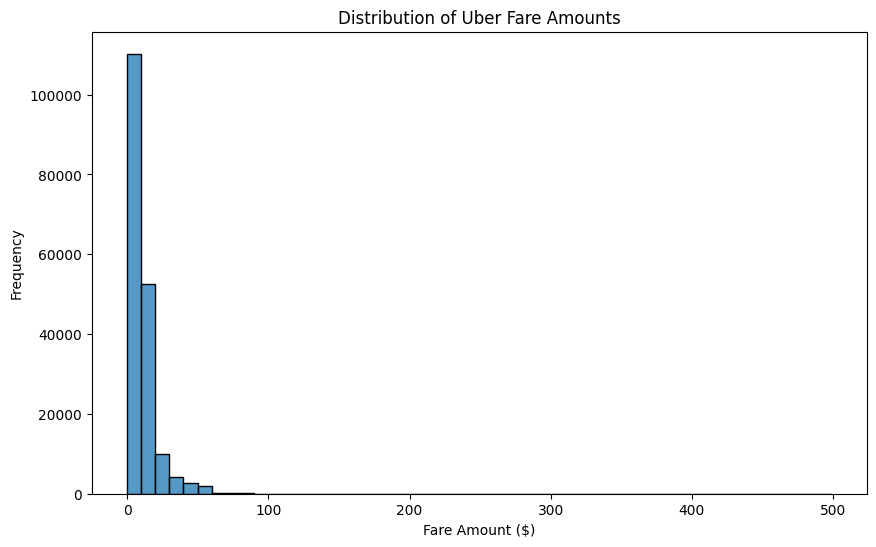

In [17]:

# Distribution of fare_amount
plt.figure(figsize=(10, 6))
sns.histplot(merged_df['fare_amount'], bins=50)
plt.title('Distribution of Uber Fare Amounts')
plt.xlabel('Fare Amount ($)')
plt.ylabel('Frequency')
plt.show()

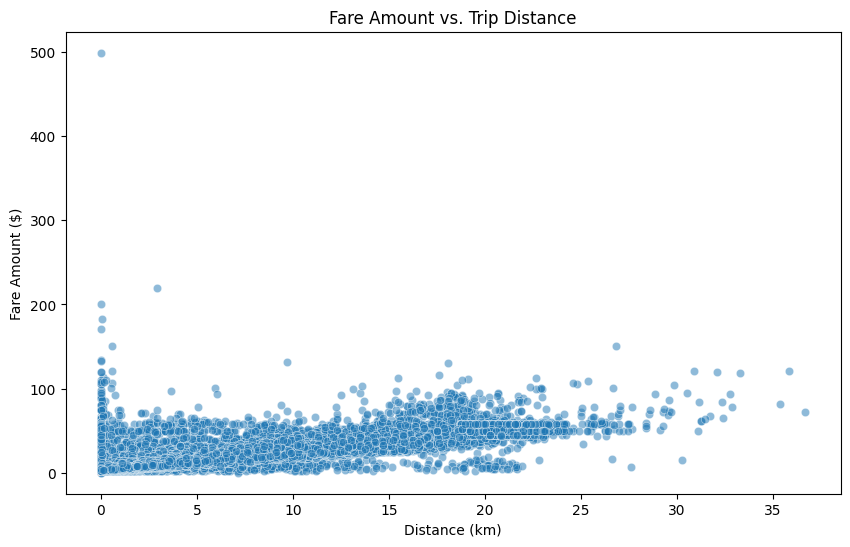

In [18]:
# Fare vs. Distance
plt.figure(figsize=(10, 6))
sns.scatterplot(x=merged_df['distance_km'], y=merged_df['fare_amount'], alpha=0.5)
plt.title('Fare Amount vs. Trip Distance')
plt.xlabel('Distance (km)')
plt.ylabel('Fare Amount ($)')
plt.show()

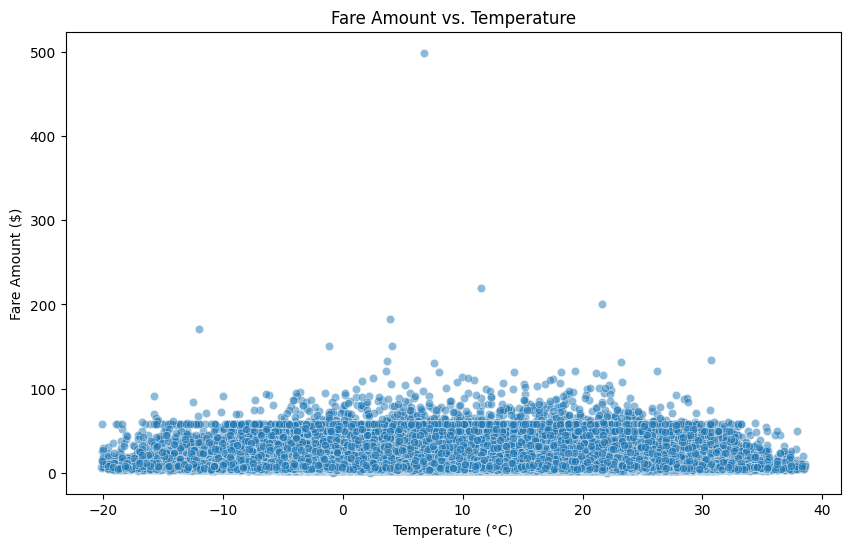

In [19]:
# Fare vs. Temperature
plt.figure(figsize=(10, 6))
sns.scatterplot(x=merged_df['temperature_2m (°C)'], y=merged_df['fare_amount'], alpha=0.5)
plt.title('Fare Amount vs. Temperature')
plt.xlabel('Temperature (°C)')
plt.ylabel('Fare Amount ($)')
plt.show()

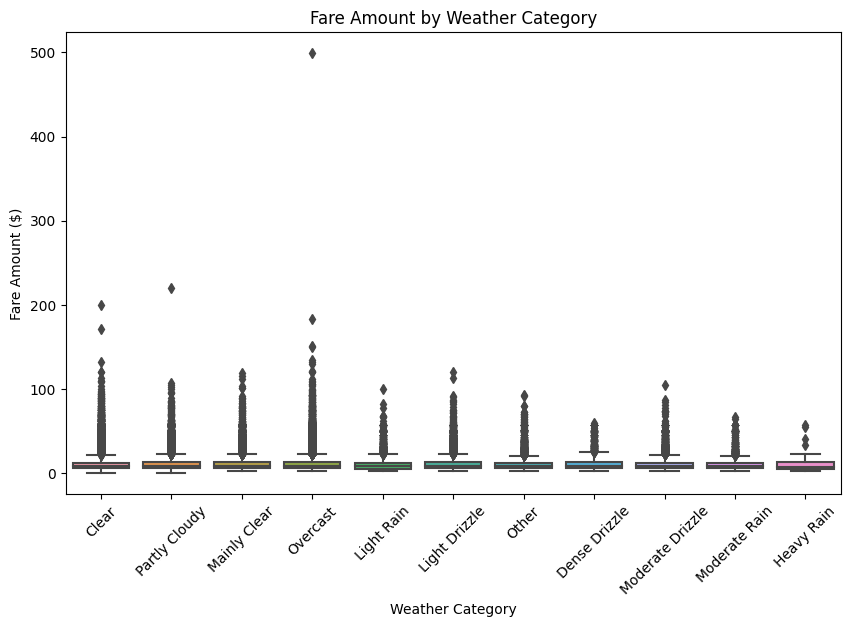

In [20]:
# Fare by Weather Category
plt.figure(figsize=(10, 6))
sns.boxplot(x=merged_df['weather_category'], y=merged_df['fare_amount'])
plt.title('Fare Amount by Weather Category')
plt.xlabel('Weather Category')
plt.ylabel('Fare Amount ($)')
plt.xticks(rotation=45)
plt.show()

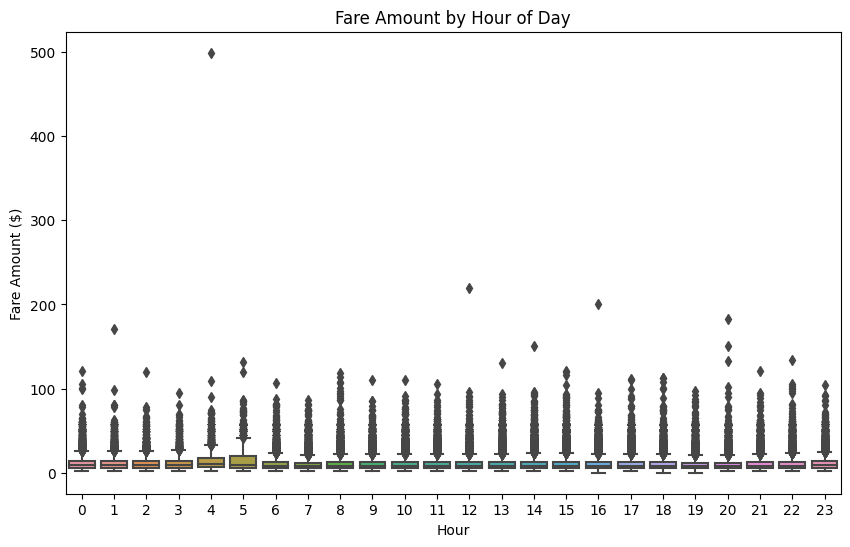

In [21]:
# Fare by Hour
plt.figure(figsize=(10, 6))
sns.boxplot(x=merged_df['hour'], y=merged_df['fare_amount'])
plt.title('Fare Amount by Hour of Day')
plt.xlabel('Hour')
plt.ylabel('Fare Amount ($)')
plt.show()

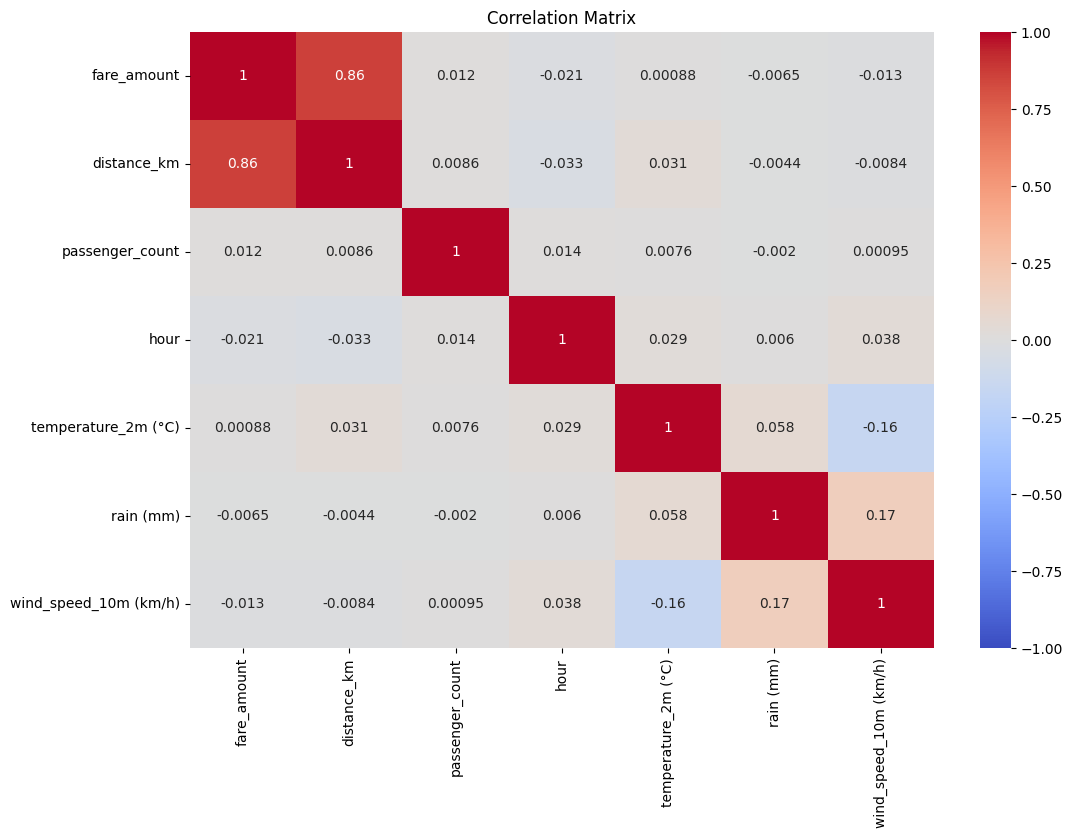

In [22]:
# Correlation matrix
plt.figure(figsize=(12, 8))
corr = merged_df[['fare_amount', 'distance_km', 'passenger_count', 'hour', 'temperature_2m (°C)', 'rain (mm)', 'wind_speed_10m (km/h)']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

In [23]:
# Save cleaned and engineered dataset
merged_df.to_csv('uber_fare_weather.csv', index=False)

In [24]:
# Print sample of merged dataset
print("Sample of Merged Dataset:")
print(merged_df[['fare_amount', 'distance_km', 'hour', 'is_weekend', 'rush_hour', 'temperature_2m (°C)', 'is_rainy', 'weather_category', 'rain_rush_hour']].head())

Sample of Merged Dataset:
   fare_amount  distance_km  hour  is_weekend  rush_hour  temperature_2m (°C)  \
0          7.5     1.683323    19           0          1                 21.4   
1          7.7     2.457590    20           0          0                 29.5   
2         12.9     5.036377    21           0          0                 26.6   
3          5.3     1.661683     8           0          1                 19.8   
4         16.0     4.475450    17           0          1                 21.6   

   is_rainy weather_category  rain_rush_hour  
0       0.0            Clear             0.0  
1       0.0    Partly Cloudy             0.0  
2       0.0    Partly Cloudy             0.0  
3       0.0     Mainly Clear             0.0  
4       0.0            Clear             0.0  


In [25]:
# Load merged dataset
merged_df = pd.read_csv('uber_fare_weather.csv')


In [26]:
# Shape of the dataset
print("Shape of the dataset:", merged_df.shape)

Shape of the dataset: (182277, 33)


In [28]:
# Summary statistics
print("\nSummary Statistics:")
print(merged_df.describe())


Summary Statistics:
         Unnamed: 0    fare_amount  pickup_longitude  pickup_latitude  \
count  1.822770e+05  182277.000000     182277.000000    182277.000000   
mean   2.772231e+07      11.409522        -73.975458        40.750743   
std    1.600223e+07       9.677491          0.034752         0.027076   
min    1.000000e+00       0.010000        -74.299012        40.508697   
25%    1.385328e+07       6.000000        -73.992300        40.736440   
50%    2.775748e+07       8.500000        -73.982123        40.753258   
75%    4.154726e+07      12.900000        -73.968396        40.767495   
max    5.542357e+07     499.000000        -73.702735        40.991651   

       dropoff_longitude  dropoff_latitude  passenger_count    distance_km  \
count      182277.000000     182277.000000    182277.000000  182277.000000   
mean          -73.974576         40.751040         1.691228       3.324109   
std             0.034287          0.030867         1.310753       3.586043   
min      

In [29]:
# Data types and non-null counts
print("\nData Types and Non-Null Counts:")
print(merged_df.info())


Data Types and Non-Null Counts:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 182277 entries, 0 to 182276
Data columns (total 33 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Unnamed: 0                 182277 non-null  int64  
 1   key                        182277 non-null  object 
 2   fare_amount                182277 non-null  float64
 3   pickup_datetime            182277 non-null  object 
 4   pickup_longitude           182277 non-null  float64
 5   pickup_latitude            182277 non-null  float64
 6   dropoff_longitude          182277 non-null  float64
 7   dropoff_latitude           182277 non-null  float64
 8   passenger_count            182277 non-null  int64  
 9   distance_km                182277 non-null  float64
 10  hour                       182277 non-null  int64  
 11  day_of_week                182277 non-null  int64  
 12  month                      182277 non-null  int64  
 

In [31]:
# Missing values
print("\nMissing Values:")
print(merged_df.isnull().sum())


Missing Values:
Unnamed: 0                   0
key                          0
fare_amount                  0
pickup_datetime              0
pickup_longitude             0
pickup_latitude              0
dropoff_longitude            0
dropoff_latitude             0
passenger_count              0
distance_km                  0
hour                         0
day_of_week                  0
month                        0
is_weekend                   0
rush_hour                    0
datetime_hour                0
time                         0
temperature_2m (°C)          0
relative_humidity_2m (%)     0
dew_point_2m (°C)            0
rain (mm)                    0
snowfall (cm)                0
precipitation (mm)           0
pressure_msl (hPa)           0
weather_code (wmo code)      0
apparent_temperature (°C)    0
wind_speed_10m (km/h)        0
snow_depth (m)               0
cloud_cover (%)              0
weather_category             0
is_rainy                     0
temp_category         

In [32]:
# Unique values in categorical columns
print("\nUnique Values in Categorical Columns:")
print("weather_category:", merged_df['weather_category'].nunique(), merged_df['weather_category'].unique())
print("temp_category:", merged_df['temp_category'].nunique(), merged_df['temp_category'].unique())


Unique Values in Categorical Columns:
weather_category: 11 ['Clear' 'Partly Cloudy' 'Mainly Clear' 'Overcast' 'Light Rain'
 'Light Drizzle' 'Other' 'Dense Drizzle' 'Moderate Drizzle'
 'Moderate Rain' 'Heavy Rain']
temp_category: 3 ['Hot' 'Mild' 'Cold']


### Potential Insights

- **Distance** is the dominant predictor of fares.
- **Rainy conditions** and **rush hours** may increase fares due to higher demand or traffic congestion.
- **Temperature** and **wind speed** have subtler effects, potentially through interactions with other variables.


**Timezone and DST Handling**:
  - **Issue**: Timezone mismatches between `uber.csv` and `weather.csv` caused merge errors, compounded by daylight saving time (DST) issues like ambiguous (`2009-11-01 01:00:00`) and nonexistent (`2010-03-14 02:00:00`) timestamps.
  - **Solution**: Used `tz_localize('US/Eastern', ambiguous='NaT', nonexistent='NaT')` to skip problematic timestamps, converting to UTC for compatibility.
  - **Note**: Always verify timezone assumptions for temporal data and explicitly handle DST transitions. Dropping minimal affected rows (12–14 hours over 2009–2015) is often a practical trade-off.

**Data Cleaning**:
  - **Issue**: Outliers and missing values risked skewing analysis.
  - **Solution**: Applied strict filters ( `fare_amount` $0–$1000, NYC coordinate bounds: latitude 40.5–41.0, longitude -74.3–-73.7) and removed missing data.
  - **Note**: Thorough cleaning ensures reliable results. Geographic filtering (NYC bounds) is critical for context-specific datasets.

**Exploratory Data Analysis (EDA) for Insights**:
  - **Issue**: Complex relationships between fares, weather, and time required visualization.
  - **Solution**: Used boxplots (fares by `weather_category`, `hour`) and correlation matrices to identify patterns like higher fares in rain or rush hours.
  - **Note**: EDA is crucial for hypothesis generation and model planning. Boxplots effectively highlight categorical effects, while correlations guide feature selection.

# Model Train and Test

In [33]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, roc_auc_score
from math import radians, sin, cos, sqrt, atan2

In [34]:
# Haversine distance function
def haversine_distance(lat1, lon1, lat2, lon2):
    R = 6371  # Earth's radius in km
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    return R * c

In [35]:
# Load merged dataset 
merged_df = pd.read_csv('uber_fare_weather.csv')

In [72]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import joblib
from math import radians, sin, cos, sqrt, atan2

# Haversine distance function
def haversine_distance(lat1, lon1, lat2, lon2):
    R = 6371  # Earth's radius in km
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    return R * c

# Ensure pickup_datetime is datetime
merged_df['pickup_datetime'] = pd.to_datetime(merged_df['pickup_datetime'])

# Calculate distance_km if not present
if 'distance_km' not in merged_df.columns:
    merged_df['distance_km'] = merged_df.apply(
        lambda row: haversine_distance(
            row['pickup_latitude'], row['pickup_longitude'],
            row['dropoff_latitude'], row['dropoff_longitude']
        ), axis=1
    )

# Ensure other features
if 'hour' not in merged_df.columns:
    merged_df['hour'] = merged_df['pickup_datetime'].dt.hour
    merged_df['day_of_week'] = merged_df['pickup_datetime'].dt.dayofweek
    merged_df['is_weekend'] = merged_df['day_of_week'].isin([5, 6]).astype(int)
    merged_df['rush_hour'] = merged_df['hour'].isin([7, 8, 9, 16, 17, 18, 19]).astype(int)

# Define features and target
fare_numerical_features = ['distance_km', 'passenger_count', 'hour', 'day_of_week', 'temperature_2m (°C)', 
                           'rain (mm)', 'wind_speed_10m (km/h)']
fare_categorical_features = ['is_weekend', 'rush_hour', 'weather_category', 'temp_category']
fare_X = merged_df[fare_numerical_features + fare_categorical_features]
fare_y = np.log1p(merged_df['fare_amount'])  # Log-transform fares

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), fare_numerical_features),
        ('cat', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), fare_categorical_features)
    ])

# Fare prediction model
fare_model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=200, max_depth=15, random_state=42))
])

# Train-test split
fare_X_train, fare_X_test, fare_y_train, fare_y_test = train_test_split(fare_X, fare_y, test_size=0.15, random_state=42)

# Train model
fare_model.fit(fare_X_train, fare_y_train)

# Save model
joblib.dump(fare_model, '/kaggle/working/uber_fare_model.pkl')
print("Model saved to /kaggle/working/uber_fare_model.pkl")

Model saved to /kaggle/working/uber_fare_model.pkl


In [73]:
# Load trained fare model
try:
    fare_model = joblib.load('/kaggle/working/uber_fare_model.pkl')
except FileNotFoundError:
    print("Error: uber_fare_model.pkl not found in /kaggle/working/. Please run the training script first.")
    exit()

# Collect user input with validation
try:
    input_data = {
        'pickup_longitude': float(input("Enter pickup longitude (e.g., -73.9857): ")),
        'pickup_latitude': float(input("Enter pickup latitude (e.g., 40.7484): ")),
        'dropoff_longitude': float(input("Enter dropoff longitude (e.g., -73.9639): ")),
        'dropoff_latitude': float(input("Enter dropoff latitude (e.g., 40.7749): ")),
        'pickup_datetime': input("Enter pickup datetime (YYYY-MM-DD HH:MM:SS, e.g., 2025-05-27 13:00:00): "),
        'passenger_count': int(input("Enter passenger count (1-6, e.g., 2): ")),
        'temperature_2m (°C)': float(input("Enter temperature in °C (e.g., 20.5): ")),
        'rain (mm)': float(input("Enter rainfall in mm (e.g., 0.0): ")),
        'wind_speed_10m (km/h)': float(input("Enter wind speed in km/h (e.g., 10.0): ")),
        'weather_category': input("Enter weather category (e.g., Clear, Light Rain, Heavy Rain): "),
        'temp_category': input("Enter temperature category (e.g., Cold, Mild, Warm): ")
    }
except ValueError as e:
    print("Error: Invalid input. Please enter numeric values for coordinates, passenger count, temperature, rain, and wind speed, and a valid datetime format.")
    exit()

# Create DataFrame for input
input_df = pd.DataFrame([input_data])

# Feature engineering
try:
    input_df['pickup_datetime'] = pd.to_datetime(input_df['pickup_datetime'])
except ValueError:
    print("Error: Invalid datetime format. Use YYYY-MM-DD HH:MM:SS (e.g., 2025-05-27 13:00:00).")
    exit()

input_df['distance_km'] = input_df.apply(
    lambda row: haversine_distance(
        row['pickup_latitude'], row['pickup_longitude'],
        row['dropoff_latitude'], row['dropoff_longitude']
    ), axis=1
)
input_df['hour'] = input_df['pickup_datetime'].dt.hour
input_df['day_of_week'] = input_df['pickup_datetime'].dt.dayofweek
input_df['is_weekend'] = input_df['day_of_week'].isin([5, 6]).astype(int)
input_df['rush_hour'] = input_df['hour'].isin([7, 8, 9, 16, 17, 18, 19]).astype(int)

# Select features for prediction
features = ['distance_km', 'passenger_count', 'hour', 'day_of_week', 'temperature_2m (°C)', 
            'rain (mm)', 'wind_speed_10m (km/h)', 'is_weekend', 'rush_hour', 
            'weather_category', 'temp_category']
try:
    X_input = input_df[features]
except KeyError as e:
    print(f"Error: Missing feature {e}. Ensure all required features are provided.")
    exit()

# Predict fare (log-transformed)
try:
    log_fare_pred = fare_model.predict(X_input)
except ValueError as e:
    print(f"Error during prediction: {e}. Ensure weather_category and temp_category match training data.")
    print("Valid categories:")
    try:
        df = pd.read_csv('/kaggle/working/uber_fare_weather.csv')
        print("Weather categories:", df['weather_category'].unique())
        print("Temperature categories:", df['temp_category'].unique())
    except:
        print("Could not load uber_fare_weather.csv to check categories.")
    exit()

# Convert back to original scale
fare_pred = np.expm1(log_fare_pred[0])  # Reverse log1p transformation
print(f"Predicted Fare Amount: ${fare_pred:.2f}")

Enter pickup longitude (e.g., -73.9857):  -73.9998168945312
Enter pickup latitude (e.g., 40.7484):  40.738353729248
Enter dropoff longitude (e.g., -73.9639):  -73.99951171875
Enter dropoff latitude (e.g., 40.7749):  40.723217010498
Enter pickup datetime (YYYY-MM-DD HH:MM:SS, e.g., 2025-05-27 13:00:00):  2015-05-07 19:52:06
Enter passenger count (1-6, e.g., 2):  1
Enter temperature in °C (e.g., 20.5):  21.4
Enter rainfall in mm (e.g., 0.0):  0
Enter wind speed in km/h (e.g., 10.0):  2.4
Enter weather category (e.g., Clear, Light Rain, Heavy Rain):  Clear
Enter temperature category (e.g., Cold, Mild, Warm):  Hot


Predicted Fare Amount: $7.45


In [80]:

from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score
# Ensure pickup_datetime is datetime
merged_df['pickup_datetime'] = pd.to_datetime(merged_df['pickup_datetime'])

# Prepare Trip Generation Probability Data
# Create 1 km x 1 km grid for NYC (approx. 0.009 degrees latitude/longitude per km)
merged_df['grid_lat'] = (merged_df['pickup_latitude'] / 0.009).round().astype(int)
merged_df['grid_lon'] = (merged_df['pickup_longitude'] / 0.009).round().astype(int)
merged_df['grid_id'] = merged_df['grid_lat'].astype(str) + '_' + merged_df['grid_lon'].astype(str)

# Aggregate trips by grid cell, hour, and date
merged_df['date_hour'] = merged_df['pickup_datetime'].dt.floor('h')
trip_counts = merged_df.groupby(['grid_id', 'date_hour', 'hour', 'day_of_week', 'is_weekend', 
                                'rush_hour', 'temperature_2m (°C)', 'rain (mm)', 
                                'wind_speed_10m (km/h)', 'weather_category', 'temp_category'])\
                     .agg({'pickup_latitude': 'count'})\
                     .rename(columns={'pickup_latitude': 'trip_count'})\
                     .reset_index()

# Label trips (1 if trip_count > 0, else 0)
trip_counts['has_trip'] = (trip_counts['trip_count'] > 0).astype(int)

# Optimized negative sampling
np.random.seed(42)
grid_ids = trip_counts['grid_id'].unique()
date_hours = trip_counts['date_hour'].unique()
sample_size = min(2000, int(0.2 * len(date_hours)))  # 20% or 2000 date_hours
sampled_date_hours = np.random.choice(date_hours, size=sample_size, replace=False)

negative_samples = []
for date_hour in sampled_date_hours:
    existing_grids = trip_counts[trip_counts['date_hour'] == date_hour]['grid_id'].values
    non_trip_grids = np.random.choice(grid_ids, size=10, replace=False)  # 10 non-trip grids
    non_trip_grids = [g for g in non_trip_grids if g not in existing_grids]
    sample = trip_counts[trip_counts['date_hour'] == date_hour][['hour', 'day_of_week', 
                                                                'is_weekend', 'rush_hour', 
                                                                'temperature_2m (°C)', 
                                                                'rain (mm)', 
                                                                'wind_speed_10m (km/h)', 
                                                                'weather_category', 
                                                                'temp_category']].iloc[0]
    for grid in non_trip_grids:
        negative_samples.append({
            'grid_id': grid, 'date_hour': date_hour, 'has_trip': 0,
            **sample.to_dict()
        })

negative_df = pd.DataFrame(negative_samples)
combined_df = pd.concat([trip_counts, negative_df], ignore_index=True)

# Define Features and Target
numerical_features = ['hour', 'day_of_week', 'temperature_2m (°C)', 'rain (mm)', 'wind_speed_10m (km/h)']
categorical_features = ['is_weekend', 'rush_hour', 'weather_category', 'temp_category']
X = combined_df[numerical_features + categorical_features]
y = combined_df['has_trip']

# Preprocessing Pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), categorical_features)
    ])

# Random Forest Classifier Model
model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=200, max_depth=15, random_state=42))
])

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train Model
model.fit(X_train, y_train)

# Evaluate Model
trip_prob = model.predict_proba(X_test)[:, 1]  # Probability of has_trip=1
trip_pred_binary = (trip_prob >= 0.5).astype(int)
roc_auc = roc_auc_score(y_test, trip_prob)
accuracy = accuracy_score(y_test, trip_pred_binary)
precision = precision_score(y_test, trip_pred_binary, zero_division=0)
recall = recall_score(y_test, trip_pred_binary, zero_division=0)
print(f"Trip Probability - ROC AUC: {roc_auc:.2f}, Accuracy: {accuracy:.2f}, "
      f"Precision: {precision:.2f}, Recall: {recall:.2f}")

# Feature Importance
feature_names = (numerical_features + 
                 model.named_steps['preprocessor']
                 .named_transformers_['cat']
                 .get_feature_names_out(categorical_features).tolist())
importances = model.named_steps['classifier'].feature_importances_
for name, imp in zip(feature_names, importances):
    print(f"Feature: {name}, Importance: {imp:.4f}")


Trip Probability - ROC AUC: 0.96, Accuracy: 0.90, Precision: 0.91, Recall: 1.00
Feature: hour, Importance: 0.1651
Feature: day_of_week, Importance: 0.0810
Feature: temperature_2m (°C), Importance: 0.2959
Feature: rain (mm), Importance: 0.0437
Feature: wind_speed_10m (km/h), Importance: 0.2990
Feature: is_weekend_1, Importance: 0.0116
Feature: rush_hour_1, Importance: 0.0118
Feature: weather_category_Dense Drizzle, Importance: 0.0025
Feature: weather_category_Heavy Rain, Importance: 0.0001
Feature: weather_category_Light Drizzle, Importance: 0.0061
Feature: weather_category_Light Rain, Importance: 0.0037
Feature: weather_category_Mainly Clear, Importance: 0.0137
Feature: weather_category_Moderate Drizzle, Importance: 0.0047
Feature: weather_category_Moderate Rain, Importance: 0.0020
Feature: weather_category_Other, Importance: 0.0051
Feature: weather_category_Overcast, Importance: 0.0148
Feature: weather_category_Partly Cloudy, Importance: 0.0126
Feature: temp_category_Hot, Importance: 

In [75]:
# Save Model
joblib.dump(model, '/kaggle/working/uber_trip_probability_model.pkl')
print("Model saved to /kaggle/working/uber_trip_probability_model.pkl")

Model saved to /kaggle/working/uber_trip_probability_model.pkl


In [76]:

# Load trained trip probability model
try:
    model = joblib.load('/kaggle/working/uber_trip_probability_model.pkl')
except FileNotFoundError:
    print("Error: uber_trip_probability_model.pkl not found in /kaggle/working/. Please run the training script first.")
    exit()

# Collect user input with validation
try:
    input_data = {
        'hour': int(input("Enter hour (0-23, e.g., 13): ")),
        'day_of_week': int(input("Enter day of week (0-6, 0=Monday, e.g., 1 for Tuesday): ")),
        'is_weekend': int(input("Enter is_weekend (0 or 1, e.g., 0): ")),
        'rush_hour': int(input("Enter rush_hour (0 or 1, e.g., 0): ")),
        'temperature_2m (°C)': float(input("Enter temperature in °C (e.g., 20.5): ")),
        'rain (mm)': float(input("Enter rainfall in mm (e.g., 0.0): ")),
        'wind_speed_10m (km/h)': float(input("Enter wind speed in km/h (e.g., 10.0): ")),
        'weather_category': input("Enter weather category (e.g., Clear, Light Rain, Heavy Rain): "),
        'temp_category': input("Enter temperature category (e.g., Cold, Medium, Warm): ")
    }
except ValueError as e:
    print(f"Error: Invalid input. Please enter numeric values for hour, day_of_week, is_weekend, rush_hour, temperature, rain, and wind speed.")
    exit()

# Create DataFrame for input
input_df = pd.DataFrame([input_data])

# Define features for prediction
features = ['hour', 'day_of_week', 'temperature_2m (°C)', 'rain (mm)', 'wind_speed_10m (km/h)', 
            'is_weekend', 'rush_hour', 'weather_category', 'temp_category']
try:
    X_input = input_df[features]
except KeyError as e:
    print(f"Error: Missing feature {e}. Ensure all required features are provided.")
    exit()

# Predict trip generation probability
try:
    trip_prob = model.predict_proba(X_input)[:, 1][0]  # Probability of has_trip=1
    print(f"Predicted Trip Generation Probability: {trip_prob:.2%}")
except ValueError as e:
    print(f"Error: Prediction failed: {e}. Ensure weather_category and temp_category match training data.")
    print("Valid categories:")
    try:
        df = pd.read_csv('/kaggle/working/uber_fare_weather.csv')
        print("Weather categories:", df['weather_category'].unique())
        print("Temperature categories:", df['temp_category'].unique())
    except:
        print("Could not load uber_fare_weather.csv to check categories.")
    exit()


Enter hour (0-23, e.g., 13):  19
Enter day of week (0-6, 0=Monday, e.g., 1 for Tuesday):  3
Enter is_weekend (0 or 1, e.g., 0):  0
Enter rush_hour (0 or 1, e.g., 0):  1
Enter temperature in °C (e.g., 20.5):  21.4
Enter rainfall in mm (e.g., 0.0):  0
Enter wind speed in km/h (e.g., 10.0):  2.4
Enter weather category (e.g., Clear, Light Rain, Heavy Rain):  Clear
Enter temperature category (e.g., Cold, Medium, Warm):  Hot


Predicted Trip Generation Probability: 93.66%


fare_X_test samples: 54684
fare_y_test samples: 54684
fare_pred samples: 54684
Fare Prediction RMSE: 0.2568
Fare Prediction MAE: 0.1760
Fare Prediction R^2 Score: 0.7799


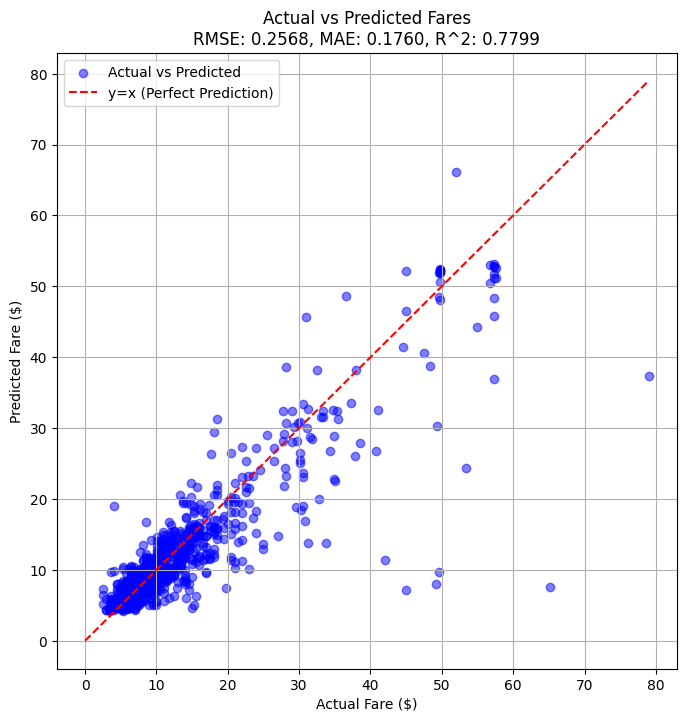

In [79]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


# Define features and target for fare prediction
fare_numerical_features = ['distance_km', 'passenger_count', 'hour', 'day_of_week', 'temperature_2m (°C)', 
                           'rain (mm)', 'wind_speed_10m (km/h)']
fare_categorical_features = ['is_weekend', 'rush_hour', 'weather_category', 'temp_category']
fare_X = merged_df[fare_numerical_features + fare_categorical_features]
fare_y = np.log1p(merged_df['fare_amount'])  # Log-transform fares

# Handle missing values
merged_df = merged_df.dropna(subset=['fare_amount'] + fare_numerical_features + fare_categorical_features)
fare_X = merged_df[fare_numerical_features + fare_categorical_features]
fare_y = np.log1p(merged_df['fare_amount'])

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), fare_numerical_features),
        ('cat', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), fare_categorical_features)
    ])

# Fare prediction model
fare_model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=200, max_depth=15, random_state=42))
])

# Train-test split
fare_X_train, fare_X_test, fare_y_train, fare_y_test = train_test_split(fare_X, fare_y, test_size=0.3, random_state=42)

# Verify sample sizes
print(f"fare_X_test samples: {fare_X_test.shape[0]}")
print(f"fare_y_test samples: {fare_y_test.shape[0]}")

# Train model
fare_model.fit(fare_X_train, fare_y_train)

# Predict fares
fare_pred = fare_model.predict(fare_X_test)

# Verify prediction size
print(f"fare_pred samples: {fare_pred.shape[0]}")

# Calculate metrics
fare_rmse = np.sqrt(mean_squared_error(fare_y_test, fare_pred))
fare_mae = mean_absolute_error(fare_y_test, fare_pred)
fare_r2 = r2_score(fare_y_test, fare_pred)
print(f"Fare Prediction RMSE: {fare_rmse:.4f}")
print(f"Fare Prediction MAE: {fare_mae:.4f}")
print(f"Fare Prediction R^2 Score: {fare_r2:.4f}")

# Convert log-fares to dollars for visualization
actual_fares = np.expm1(fare_y_test)
predicted_fares = np.expm1(fare_pred)

# Prepare scatter plot (limit to 1000 points for clarity)
max_points = 1000
indices = np.random.choice(len(actual_fares), min(max_points, len(actual_fares)), replace=False)
plot_actual = actual_fares.iloc[indices].values  # Use .iloc for Pandas Series
plot_predicted = predicted_fares[indices]        # Use NumPy indexing for array

# Create scatter plot
plt.figure(figsize=(8, 8))
plt.scatter(plot_actual, plot_predicted, alpha=0.5, color='blue', label='Actual vs Predicted')
max_val = max(max(plot_actual), max(plot_predicted))
plt.plot([0, max_val], [0, max_val], color='red', linestyle='--', label='y=x (Perfect Prediction)')
plt.xlabel('Actual Fare ($)')
plt.ylabel('Predicted Fare ($)')
plt.title(f'Actual vs Predicted Fares\nRMSE: {fare_rmse:.4f}, MAE: {fare_mae:.4f}, R^2: {fare_r2:.4f}')
plt.legend()
plt.grid(True)
plt.show()

In [81]:
# Example input for prediction at a specific time
input_data = pd.DataFrame({
    'hour': [8],  # e.g., 8 AM
    'temperature_2m (°C)': [20.0],  # Example weather value
    'rain (mm)': [0.0],  # No rain
    'wind_speed_10m (km/h)': [10.0],  # Example wind speed
    'is_weekend': [0],  # Weekday (0 = no, 1 = yes)
    'rush_hour': [1],  # Morning rush hour (1 = yes)
    'weather_category': ['clear'],  # Example weather category
    'temp_category': ['moderate']  # Example temperature category
})

# Predict trip generation probability
trip_proba = trip_model.predict_proba(input_data)[:, 1][0]
print(f"Trip Generation Probability at 8 AM: {trip_proba:.4f}")

Trip Generation Probability at 8 AM: 0.2735


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [83]:
# Define location (example: near Times Square, NYC)
pickup_latitude = 40.7580
pickup_longitude = -73.9855

# Map location to area_id using the same grid as training
lat_bins = np.linspace(merged_df['pickup_latitude'].min(), merged_df['pickup_latitude'].max(), 20)
lon_bins = np.linspace(merged_df['pickup_longitude'].min(), merged_df['pickup_longitude'].max(), 20)
lat_bin = pd.cut([pickup_latitude], bins=lat_bins, labels=False, include_lowest=True)[0]
lon_bin = pd.cut([pickup_longitude], bins=lon_bins, labels=False, include_lowest=True)[0]
area_id = f"{lat_bin}_{lon_bin}"

# Example input for prediction at this location
input_data = pd.DataFrame({
    'hour': [8],  # 8 AM
    'temperature_2m (°C)': [20.0],  # Example weather
    'rain (mm)': [0.0],  # No rain
    'wind_speed_10m (km/h)': [10.0],  # Example wind speed
    'is_weekend': [0],  # Weekday
    'rush_hour': [1],  # Morning rush hour
    'weather_category': ['clear'],  # Example weather
    'temp_category': ['moderate']  # Example temp
})

# Predict trip generation probability
trip_proba = trip_model.predict_proba(input_data)[:, 1][0]
print(f"Trip Generation Probability at ({pickup_latitude}, {pickup_longitude}): {trip_proba:.4f}")

Trip Generation Probability at (40.758, -73.9855): 0.2735


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [85]:
# Get valid categories and location bounds from merged_df
valid_weather_categories = merged_df['weather_category'].unique().tolist()
valid_temp_categories = merged_df['temp_category'].unique()
lat_min, lat_max = merged_df['pickup_latitude'].min(), merged_df['pickup_latitude'].max()
lon_min, lon_max = merged_df['pickup_longitude'].min(), merged_df['pickup_longitude'].max()

# Initialize input dictionary
user_input = {}

try:
    # latitude
    pickup_latitude = float(input(f"Enter pickup latitude ({lat_min:.4f} to {lat_max:.4f}): "))
    if lat_min <= pickup_latitude <= lat_max:
        lat_input = pickup_latitude
    else:
        raise ValueError(f"Latitude must be between {lat_min:.4f} and {lat_max:.4f}.")

    # longitude
    pickup_longitude = float(input(f"Enter pickup longitude ({lon_min:.4f} to {lon_max:.4f}): "))
    if lon_min <= pickup_longitude <= lon_max:
        lon_input = pickup_longitude
    else:
        raise ValueError(f"Longitude must be between {lon_min:.4f} and {lon_max:.4f}.")

    # Map location to area_id
    lat_bins = np.linspace(lat_min, lat_max, 20)
    lon_bins = np.linspace(lon_min, lon_max, 20)
    lat_bin = pd.cut([lat_input], bins=lat_bins, labels=False, include_lowest=True)[0]
    lon_bin = pd.cut([lon_input], bins=lon_bins, labels=False, include_lowest=True)[0]
    area_id = f"{lat_bin}_{lon_bin}"

    # hour
    hour = int(input("Enter hour (0-23): "))
    if 0 <= hour <= 23:
        user_input['hour'] = hour
    else:
        raise ValueError("Hour must be between 0 and 23.")

    # temperature
    temperature = float(input("Enter temperature (°C): "))
    user_input['temperature_2m (°C)'] = temperature

    # rain
    rain = float(input("Enter rainfall (mm): "))
    if rain >= 0:
        user_input['rain (mm)'] = rain
    else:
        raise ValueError("Rainfall must be non-negative.")

    # wind speed
    wind_speed = float(input("Enter wind speed (km/h): "))
    if wind_speed >= 0:
        user_input['wind_speed_10m (km/h)'] = wind_speed
    else:
        raise ValueError("Wind speed must be non-negative.")

    # is_weekend
    is_weekend = input("Is it a weekend? (yes/no): ").lower()
    if is_weekend in ['yes', 'no']:
        user_input['is_weekend'] = 1 if is_weekend == 'yes' else 0
    else:
        raise ValueError("Please enter 'yes' or 'no' for weekend status.")

    # rush_hour
    rush_hour = input("Is it rush hour? (yes/no): ").lower()
    if rush_hour in ['yes', 'no']:
        user_input['rush_hour'] = 1 if rush_hour == 'yes' else 0
    else:
        raise ValueError("Please enter 'yes' or 'no' for rush hour status.")

    # weather_category
    print("Available weather categories:", valid_weather_categories)
    weather_category = input("Enter weather category: ").lower()
    if weather_category in [cat.lower() for cat in valid_weather_categories]:
        user_input['weather_category'] = weather_category
    else:
        raise ValueError(f"Weather category must be one of {valid_weather_categories}.")

    # temp_category
    print("Available temperature categories:", valid_temp_categories)
    temp_category = input("Enter temperature category: ").lower()
    if temp_category in [cat.lower() for cat in valid_temp_categories]:
        user_input['temp_category'] = temp_category
    else:
        raise ValueError(f"Temperature category must be one of {valid_temp_categories}.")

    # Create input DataFrame
    input_data = pd.DataFrame([user_input])

    # Predict trip generation probability
    trip_proba = trip_model.predict_proba(input_data)[:, 1][0]
    print(f"Trip Generation Probability at ({lat_input:.4f}, {lon_input:.4f}): {trip_proba:.4f}")

except ValueError as e:
    print(f"Input Error: {e}")
except Exception as e:
    print(f"An error occurred: {e}")

Enter pickup latitude (40.5087 to 40.9917):  40.738353729248
Enter pickup longitude (-74.2990 to -73.7027):  -73.9998168945312
Enter hour (0-23):  19
Enter temperature (°C):  21.4
Enter rainfall (mm):  0
Enter wind speed (km/h):  2.4
Is it a weekend? (yes/no):  no
Is it rush hour? (yes/no):  yes


Available weather categories: ['Clear', 'Partly Cloudy', 'Mainly Clear', 'Overcast', 'Light Rain', 'Light Drizzle', 'Other', 'Dense Drizzle', 'Moderate Drizzle', 'Moderate Rain', 'Heavy Rain']


Enter weather category:  Clear


Available temperature categories: ['Hot' 'Mild' 'Cold']


Enter temperature category:  Hot


Trip Generation Probability at (40.7384, -73.9998): 0.3512


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
